<a href="https://colab.research.google.com/github/nbadino/ItaOil/blob/main/oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prima bozza del paper di policy evaluation sui prezzi del carburante dopo che i prezzi medi verranno esposti al di fuori di ogni distributore

In [2]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import geopandas as gpd

#shutil.rmtree('/content/ItaOil-main')

# Check if file exists
if not os.path.isfile("/content/main.zip"):
    print("File not found, downloading...")
    # Execute wget command
    try:
        subprocess.check_call(['wget', 'https://github.com/nbadino/ItaOil/archive/refs/heads/main.zip', '-P', '/content'])
        print("File downloaded, unzipping...")
        subprocess.check_call(['unzip', "/content/main.zip", '-d', '/content'])
    except subprocess.CalledProcessError as e:
        print("Could not download or unzip file: ", e)
else:
    print("File exists.")

os.chdir("/content/ItaOil-main")


File exists.


In [16]:
import datetime
import os
import pandas as pd

# Define the paths to your datasets
price_filepath = '/content/ItaOil-main/data/nuovi/prices'
gas_station_filepath = '/content/ItaOil-main/data/nuovi/gas_station_info'

# List the .csv files in your directories
price_files = [f for f in os.listdir(price_filepath) if f.endswith('.csv')]
gas_station_files = [f for f in os.listdir(gas_station_filepath) if f.endswith('.csv')]

# Read in your datasets and add a date column with the year set to 2023
price_data = pd.concat([
    pd.read_csv(os.path.join(price_filepath, f), sep=';', skiprows=1, error_bad_lines=False)
    .assign(date=datetime.datetime.strptime(f[6:10], '%m%d').replace(year=2023))
    for f in price_files
])

gas_station_data = pd.concat([
    pd.read_csv(os.path.join(gas_station_filepath, f), sep=';', skiprows=1, error_bad_lines=False)
    .assign(date=datetime.datetime.strptime(f[5:9], '%m%d').replace(year=2023))
    for f in gas_station_files
])

<ipython-input-16-0e8e7ba0a1e4>:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv(os.path.join(price_filepath, f), sep=';', skiprows=1, error_bad_lines=False)
<ipython-input-16-0e8e7ba0a1e4>:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv(os.path.join(price_filepath, f), sep=';', skiprows=1, error_bad_lines=False)
<ipython-input-16-0e8e7ba0a1e4>:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv(os.path.join(price_filepath, f), sep=';', skiprows=1, error_bad_lines=False)
<ipython-input-16-0e8e7ba0a1e4>:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv(os.path.join(

In [17]:
merged_data = pd.merge(price_data, gas_station_data, on='idImpianto')


In [18]:
# convert 'dtComu' to datetime
merged_data['dtComu'] = pd.to_datetime(merged_data['dtComu'])

# create a dictionary where the keys are the 'descCarburante' categories and the values are the corresponding datasets
time_series_data = {category: merged_data[merged_data['descCarburante'] == category].sort_values('dtComu') for category in merged_data['descCarburante'].unique()}


In [19]:
# create a dictionary where the keys are tuples in the form (descCarburante category, isSelf value) and the values are the corresponding datasets
self_data = {(category, is_self): merged_data[(merged_data['descCarburante'] == category) & (merged_data['isSelf'] == is_self)].sort_values('dtComu') for category in merged_data['descCarburante'].unique() for is_self in [0, 1]}


<ipython-input-20-dc417b4a8440>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benzina_self_0['date_x'] = pd.to_datetime(benzina_self_0['date_x'])
<ipython-input-20-dc417b4a8440>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benzina_self_1['date_x'] = pd.to_datetime(benzina_self_1['date_x'])


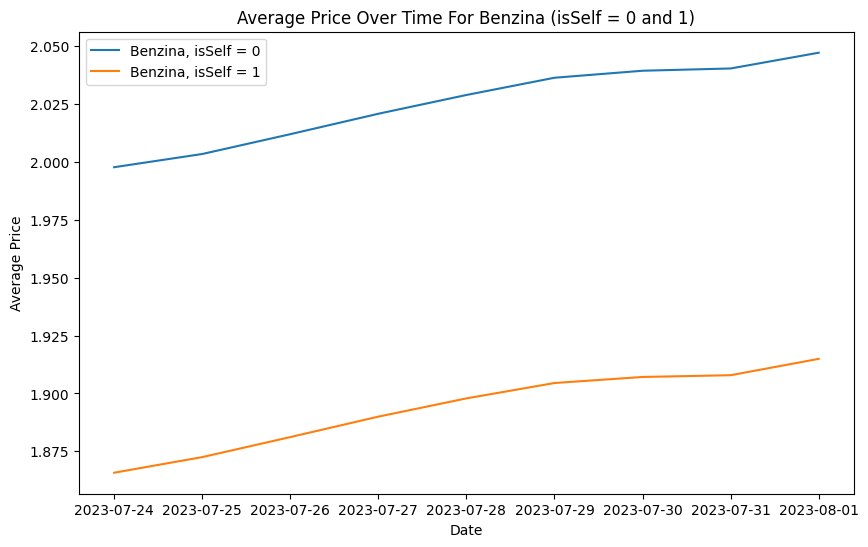

In [20]:
# Subset the data for 'Benzina' where 'isSelf' is 0 or 1
benzina_self_0 = merged_data[(merged_data['descCarburante'] == 'Benzina') & (merged_data['isSelf'] == 0)]
benzina_self_1 = merged_data[(merged_data['descCarburante'] == 'Benzina') & (merged_data['isSelf'] == 1)]

# Make sure 'dtComu' is datetime
benzina_self_0['date_x'] = pd.to_datetime(benzina_self_0['date_x'])
benzina_self_1['date_x'] = pd.to_datetime(benzina_self_1['date_x'])

# Group by date and calculate mean price
benzina_self_0_grouped = benzina_self_0.groupby(benzina_self_0['date_x'].dt.date)['prezzo'].mean()
benzina_self_1_grouped = benzina_self_1.groupby(benzina_self_1['date_x'].dt.date)['prezzo'].mean()

# Plot the time series of average prices for 'Benzina' where 'isSelf' is 0 or 1
plt.figure(figsize=(10, 6))
plt.plot(benzina_self_0_grouped.index, benzina_self_0_grouped.values, label='Benzina, isSelf = 0')
plt.plot(benzina_self_1_grouped.index, benzina_self_1_grouped.values, label='Benzina, isSelf = 1')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price Over Time For Benzina (isSelf = 0 and 1)')
plt.legend()
plt.show()


In [21]:
# Drop rows with missing coordinates
merged_data = merged_data.dropna(subset=['Latitudine', 'Longitudine'])

# Drop rows with out-of-range coordinates
merged_data = merged_data[((merged_data['Latitudine'] >= -90) & (merged_data['Latitudine'] <= 90) & (merged_data['Longitudine'] >= -180) & (merged_data['Longitudine'] <= 180))]


In [22]:
!pip install geopy reverse_geocoder

import reverse_geocoder as rg
import numpy as np

# Convert latitude and longitude to float type
merged_data['Latitudine'] = merged_data['Latitudine'].astype(float)
merged_data['Longitudine'] = merged_data['Longitudine'].astype(float)

# Create a list of tuples from the latitude and longitude columns
coordinates = list(zip(merged_data['Latitudine'], merged_data['Longitudine']))

# Use reverse_geocoder to get the regions
results = rg.search(coordinates)

# Extract the region name from the results and add it to the DataFrame
merged_data['region'] = [r['admin1'] for r in results]


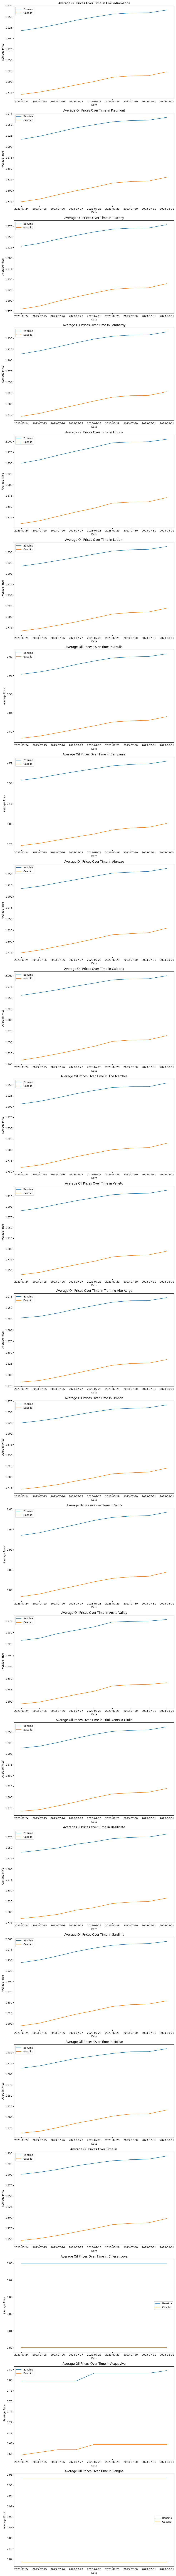

In [32]:
# Define the fuel types of interest
fuel_types = ['Benzina', 'Gasolio']

# Filter the data to include only the selected fuel types
filtered_data = merged_data[merged_data['descCarburante'].isin(fuel_types)]

# Get unique regions
regions = filtered_data['region'].unique()

# Create a figure with one subplot for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 6*len(regions)))

# Plot the data for each region
for i, region in enumerate(regions):
    for fuel_type in fuel_types:
        # Subset the data for the current region and fuel type
        data = filtered_data[(filtered_data['region'] == region) & (filtered_data['descCarburante'] == fuel_type)]

        # Calculate the mean price by date
        data_grouped_by_date = data.groupby('date_x')['prezzo'].mean()
        # Plot the data
        axs[i].plot(data_grouped_by_date.index, data_grouped_by_date.values, label=fuel_type)

    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Average Price')
    axs[i].set_title(f'Average Oil Prices Over Time in {region}')
    axs[i].legend()

plt.tight_layout()
plt.show()



In [33]:
data_grouped_by_date.head()

date_x
2023-07-24    1.814
2023-07-25    1.814
2023-07-26    1.814
2023-07-27    1.814
2023-07-28    1.814
Name: prezzo, dtype: float64

The file for date 20230802 is not a valid zip file.


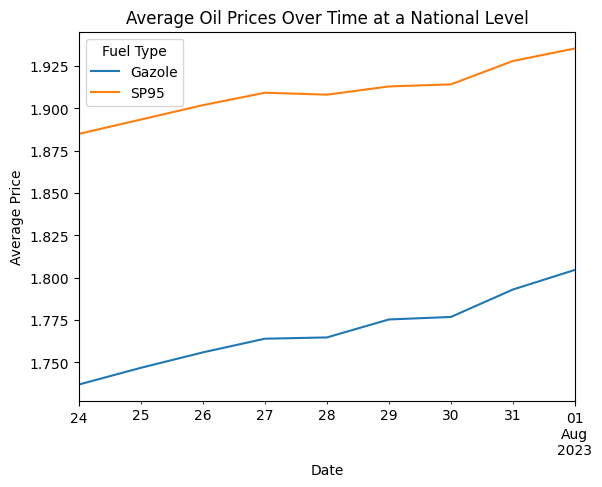

In [35]:
# Initialize an empty list to store the data
import requests
import xml.etree.ElementTree as ET
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import datetime
from zipfile import BadZipFile


# Define the fuel types of interest
fuel_types = ['Gazole', 'SP95']

data_list = []
dates = [(datetime.datetime.now() - datetime.timedelta(days=i)).strftime('%Y%m%d') for i in range(10)]

# Loop over the dates
for date in dates:
    # Download the XML file
    url = f'https://donnees.roulez-eco.fr/opendata/jour/{date}'
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        try:
            # Open the zip file
            with ZipFile(BytesIO(response.content)) as zf:
                # There should be only one file in the zip, get its name
                file_name = zf.namelist()[0]

                # Open the XML file
                with zf.open(file_name) as f:
                    # Parse the XML
                    tree = ET.parse(f)
                    root = tree.getroot()

                    # Loop over the stations
                    for pdv in root.findall('pdv'):
                        # Get the station info
                        id_ = pdv.get('id')
                        latitude = pdv.get('latitude')
                        longitude = pdv.get('longitude')
                        cp = pdv.get('cp')
                        pop = pdv.get('pop')

                        # Loop over the prices
                        for prix in pdv.findall('prix'):
                            # Get the price info
                            fuel_type = prix.get('nom')
                            price = prix.get('valeur')
                            update_time = prix.get('maj')

                            # If the fuel type is of interest, append the data to the list
                            if fuel_type in fuel_types:
                                data_list.append({'id': id_, 'latitude': latitude, 'longitude': longitude, 'cp': cp, 'pop': pop,
                                                  'fuel_type': fuel_type, 'price': price, 'update_time': update_time, 'date': date})
        except BadZipFile:
            print(f"The file for date {date} is not a valid zip file.")
    else:
        print(f"No data available for date {date}.")

# Convert the list to a DataFrame
data = pd.DataFrame(data_list)

# Convert the price to float type
data['price'] = data['price'].astype(float)

# Convert the date to datetime type
data['date'] = pd.to_datetime(data['date'])

# Calculate the mean price by date for each fuel type
data_grouped_by_date = data.groupby(['date', 'fuel_type'])['price'].mean().unstack('fuel_type')

# Plot the data
data_grouped_by_date.plot()
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Oil Prices Over Time at a National Level')
plt.legend(title='Fuel Type')
plt.show()


In [36]:
print(data_grouped_by_date)

fuel_type     Gazole      SP95
date                          
2023-07-24  1.736990  1.884967
2023-07-25  1.746868  1.893429
2023-07-26  1.755968  1.901911
2023-07-27  1.764045  1.909252
2023-07-28  1.764790  1.908100
2023-07-29  1.775397  1.912964
2023-07-30  1.776882  1.914179
2023-07-31  1.793074  1.928001
2023-08-01  1.804652  1.935350


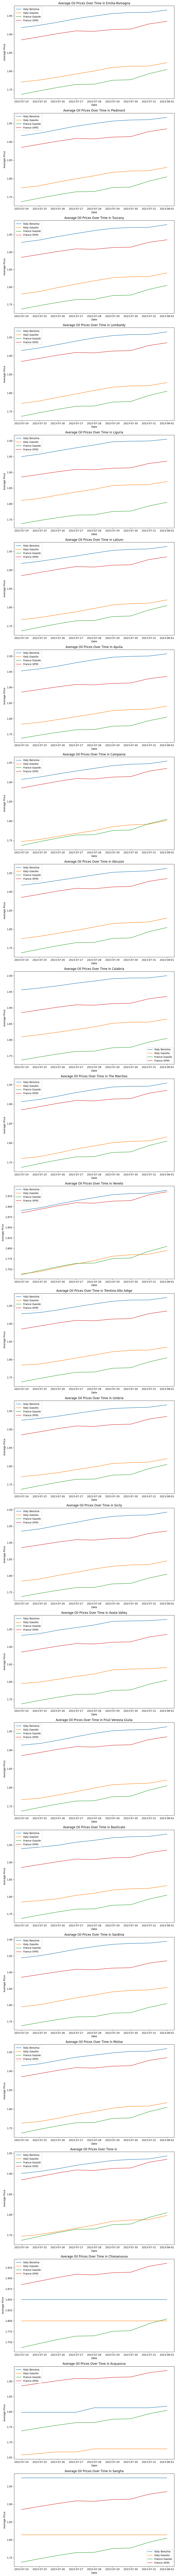

In [37]:
import matplotlib.pyplot as plt

# Define the fuel types of interest
italian_fuel_types = ['Benzina', 'Gasolio']
french_fuel_types = ['Gazole', 'SP95']

# Filter the Italian data to include only the selected fuel types
filtered_data = merged_data[merged_data['descCarburante'].isin(italian_fuel_types)]

# Get unique regions
regions = filtered_data['region'].unique()

# Create a figure with one subplot for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 6*len(regions)))

# Assuming you have the French data grouped by date
french_data_grouped_by_date = data_grouped_by_date

# Plot the data for each region
for i, region in enumerate(regions):
    for fuel_type in italian_fuel_types:
        # Subset the data for the current region and fuel type
        data = filtered_data[(filtered_data['region'] == region) & (filtered_data['descCarburante'] == fuel_type)]

        # Calculate the mean price by date
        data_grouped_by_date = data.groupby('date_x')['prezzo'].mean()

        # Plot the Italian data
        axs[i].plot(data_grouped_by_date.index, data_grouped_by_date.values, label=f'Italy {fuel_type}')

    for fuel_type in french_fuel_types:
        # Plot the French data
        axs[i].plot(french_data_grouped_by_date.index, french_data_grouped_by_date[fuel_type].values, label=f'France {fuel_type}')

    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Average Price')
    axs[i].set_title(f'Average Oil Prices Over Time in {region}')
    axs[i].legend()

plt.tight_layout()
plt.show()


KeyError: ignored

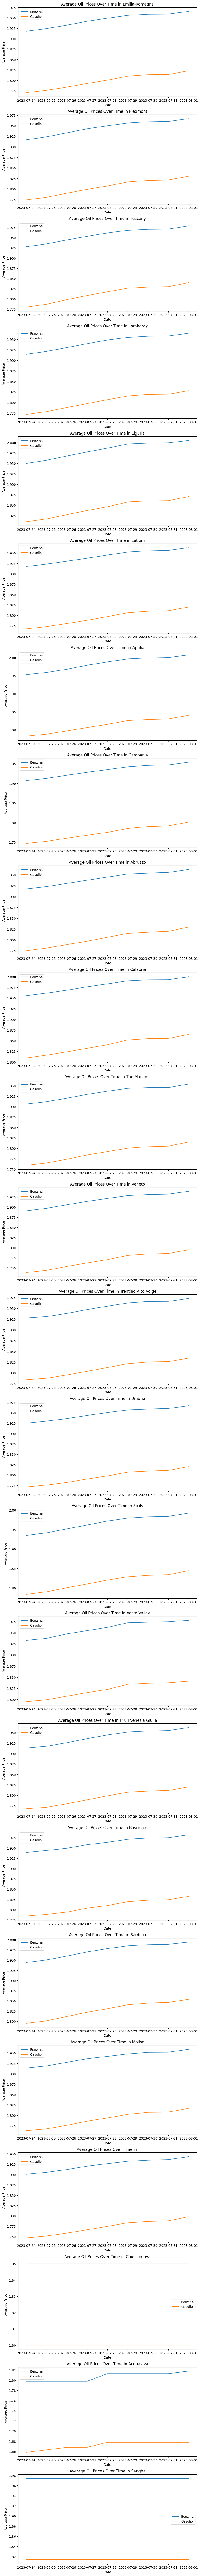

In [25]:
import matplotlib.pyplot as plt

# Define the fuel types of interest
fuel_types = ['Benzina', 'Gasolio']

# Filter the data to include only the selected fuel types
filtered_data = merged_data[merged_data['descCarburante'].isin(fuel_types)]

# Get unique regions
regions = filtered_data['region'].unique()

# Create a figure with one subplot for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 6*len(regions)))

# Plot the data for each region
for i, region in enumerate(regions):
    for fuel_type in fuel_types:
        # Subset the data for the current region and fuel type
        data = filtered_data[(filtered_data['region'] == region) & (filtered_data['descCarburante'] == fuel_type)]

        # Calculate the mean price by date
        data_grouped_by_date = data.groupby('date_x')['prezzo'].mean()

        # Plot the data
        axs[i].plot(data_grouped_by_date.index, data_grouped_by_date.values, label=fuel_type)

    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Average Price')
    axs[i].set_title(f'Average Oil Prices Over Time in {region}')
    axs[i].legend()

# Plot the French data
fuel_types = ['SP95', 'Gazole']
for fuel_type in fuel_types:
    data_grouped_by_date[fuel_type].plot(ax=axs[i], label=f'France {fuel_type}')

plt.tight_layout()
plt.show()


In [26]:
print(data_grouped_by_date.head())
print(data_grouped_by_date.columns)


date_x
2023-07-24    1.814
2023-07-25    1.814
2023-07-26    1.814
2023-07-27    1.814
2023-07-28    1.814
Name: prezzo, dtype: float64


AttributeError: ignored

In [60]:
# Convert the list to a DataFrame
data = pd.DataFrame(data_list)

# Convert the price to float type
data['price'] = data['price'].astype(float)

# Convert the date to datetime type
data['date'] = pd.to_datetime(data['date'])

# Map the French fuel types to the corresponding Italian fuel types
data['fuel_type'] = data['fuel_type'].map({'Gazole': 'Gasolio', 'SP95': 'Benzina'})

# Rename the 'price' column to 'prezzo' to match the Italian dataset
data.rename(columns={'price': 'prezzo'}, inplace=True)

# Calculate the mean price by date for each fuel type
data_grouped_by_date = data.groupby(['date', 'fuel_type'])['prezzo'].mean().unstack('fuel_type')

# Append the French data to the Italian data
merged_data = pd.concat([merged_data, data])

# Calculate the mean price by date for each fuel type and region
merged_data_grouped_by_date = merged_data.groupby(['date', 'descCarburante', 'region'])['prezzo'].mean().unstack('region')

# Plot the data
merged_data_grouped_by_date.plot()
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Oil Prices Over Time')
plt.legend(title='Region')
plt.show()


TypeError: ignored

In [67]:
# Check the structure of the merged_data (Italian data)
print(merged_data.info())
print(merged_data.head())

# Check the structure of the French data
print(data.info())
print(data.head())

# Check the structure of the merged data after adding the French data
merged_data_new = pd.concat([merged_data, data])
print(merged_data_new.info())
print(merged_data_new.head())

# Check the structure of the grouped data
merged_data_grouped_by_date = merged_data_new.groupby(['date', 'descCarburante', 'region'])['prezzo'].mean().unstack('region')
print(merged_data_grouped_by_date.info())
print(merged_data_grouped_by_date.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7978067 entries, 0 to 120002
Data columns (total 26 columns):
 #   Column          Dtype         
---  ------          -----         
 0   idImpianto      object        
 1   descCarburante  object        
 2   prezzo          float64       
 3   isSelf          float64       
 4   dtComu          object        
 5   date_x          datetime64[ns]
 6   Gestore         object        
 7   Bandiera        object        
 8   Tipo Impianto   object        
 9   Nome Impianto   object        
 10  Indirizzo       object        
 11  Comune          object        
 12  Provincia       object        
 13  Latitudine      float64       
 14  Longitudine     float64       
 15  date_y          datetime64[ns]
 16  region          object        
 17  id              object        
 18  latitude        object        
 19  longitude       object        
 20  cp              object        
 21  pop             object        
 22  fuel_type       obj

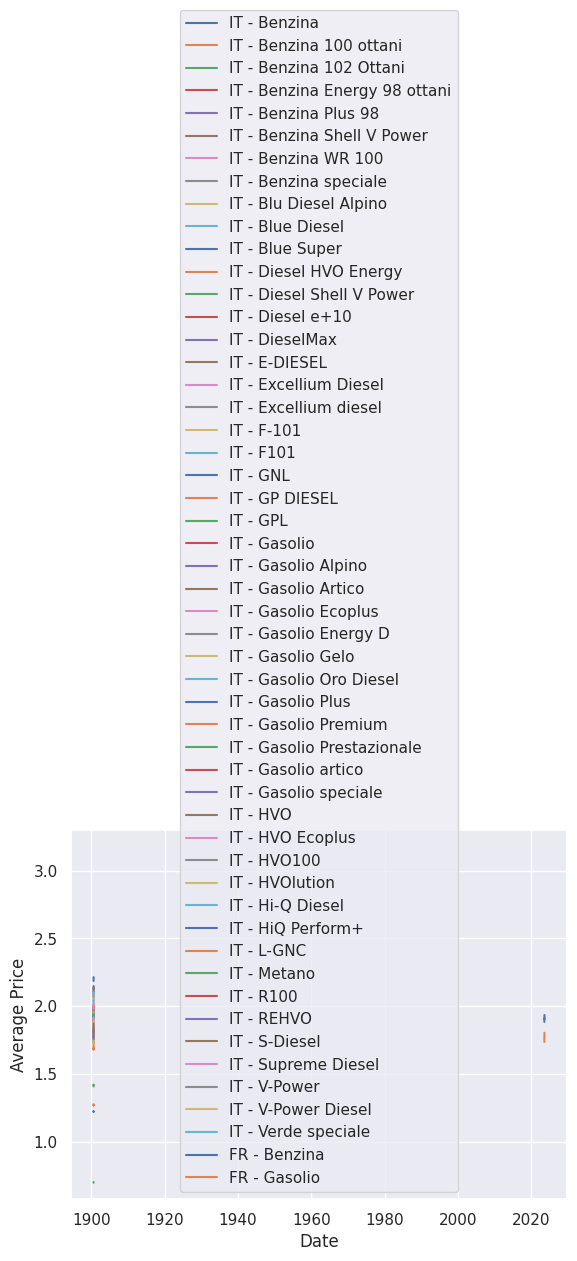

In [68]:
import matplotlib.pyplot as plt

# Group Italian data by date and fuel type, then calculate the mean price
italian_data_grouped = merged_data.groupby(['date_x', 'descCarburante'])['prezzo'].mean().unstack('descCarburante')

# Group French data by date and fuel type, then calculate the mean price
french_data_grouped = data.groupby(['date', 'descCarburante'])['prezzo'].mean().unstack('descCarburante')

# Create a new plot
fig, ax = plt.subplots()

# Add Italian data to the plot
for fuel_type in italian_data_grouped.columns:
    ax.plot(italian_data_grouped.index, italian_data_grouped[fuel_type], label=f'IT - {fuel_type}')

# Add French data to the plot
for fuel_type in french_data_grouped.columns:
    ax.plot(french_data_grouped.index, french_data_grouped[fuel_type], label=f'FR - {fuel_type}')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
ax.legend()

# Display the plot
plt.show()


***OLD DATA, KEPT JUST FOR BACKUP***

<ipython-input-16-56fec396c37a>:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  location_data = pd.read_csv('/content/ItaOil-main/data/nuovi/anagrafica_impianti_attivi 24-07.csv', sep=';', skiprows=2, names=location_column_names, error_bad_lines=False)
Skipping line 494: expected 10 fields, saw 11
Skipping line 764: expected 10 fields, saw 11
Skipping line 772: expected 10 fields, saw 11
Skipping line 1279: expected 10 fields, saw 11
Skipping line 1526: expected 10 fields, saw 11
Skipping line 2194: expected 10 fields, saw 11
Skipping line 6228: expected 10 fields, saw 11
Skipping line 7577: expected 10 fields, saw 11
Skipping line 8209: expected 10 fields, saw 11
Skipping line 8787: expected 10 fields, saw 11
Skipping line 8788: expected 10 fields, saw 11
Skipping line 8922: expected 10 fields, saw 11
Skipping line 11790: expected 10 fields, saw 11
Skipping line 12179: expected 10 fields, 

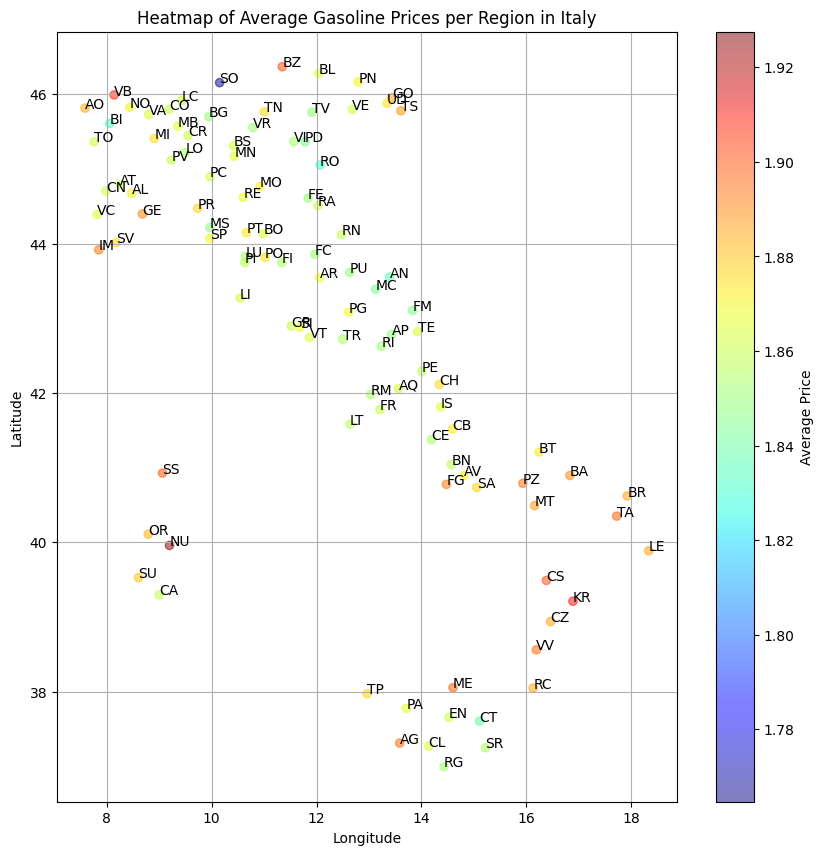

In [ ]:
# Define the column names
column_names = ['idImpianto', 'descCarburante', 'prezzo', 'isSelf', 'dtComu']

# Load the price data with the correct column names and separator
data = pd.read_csv('/content/ItaOil-main/data/nuovi/prezzo_alle_8 24-07.csv', sep=';', skiprows=1, names=column_names)

# Filter for 'Benzina' and 'isSelf'='1'
data = data[(data['descCarburante'] == 'Benzina') & (data['isSelf'] == '1')]

# Define the column names for the location data
location_column_names = ['idImpianto', 'Gestore', 'Bandiera', 'Tipo Impianto', 'Nome Impianto', 'Indirizzo', 'Comune', 'Provincia', 'Latitudine', 'Longitudine']

# Load the location data again with the correct column names

location_data = pd.read_csv('/content/ItaOil-main/data/nuovi/anagrafica_impianti_attivi 24-07.csv', sep=';', skiprows=2, names=location_column_names, error_bad_lines=False)

# Ensure 'idImpianto' is of the same type in both datasets
data['idImpianto'] = data['idImpianto'].astype(str)
location_data['idImpianto'] = location_data['idImpianto'].astype(str)

# Merge the two datasets
merged_data = pd.merge(data, location_data, on='idImpianto', how='inner')

# Convert 'Latitudine', 'Longitudine', and 'prezzo' to numeric types
merged_data['Latitudine'] = pd.to_numeric(merged_data['Latitudine'], errors='coerce')
merged_data['Longitudine'] = pd.to_numeric(merged_data['Longitudine'], errors='coerce')
merged_data['prezzo'] = pd.to_numeric(merged_data['prezzo'], errors='coerce')

# Group by 'Provincia' and calculate the mean price
region_data = merged_data.groupby('Provincia')['prezzo'].mean().reset_index()

# Merge with location data to get coordinates for each region
region_location_data = location_data.drop_duplicates('Provincia')
region_merged = pd.merge(region_data, region_location_data, on='Provincia', how='inner')

# Convert 'Latitudine' and 'Longitudine' to numeric types
region_merged['Latitudine'] = pd.to_numeric(region_merged['Latitudine'], errors='coerce')
region_merged['Longitudine'] = pd.to_numeric(region_merged['Longitudine'], errors='coerce')

# Create a scatter plot
plt.figure(figsize=(10,10))
plt.scatter(region_merged['Longitudine'], region_merged['Latitudine'], c=region_merged['prezzo'], cmap='jet', alpha=0.5)
for i, txt in enumerate(region_merged['Provincia']):
    plt.annotate(txt, (region_merged['Longitudine'].iat[i], region_merged['Latitudine'].iat[i]))
plt.colorbar(label='Average Price')
plt.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Average Gasoline Prices per Region in Italy')
plt.show()


In [ ]:
province_df = pd.read_csv('/content/ItaOil-main/data/province-sigle.csv', header=None, encoding='latin-1')

# Convert the DataFrame to a dictionary
province_mapping = province_df.set_index(0)[1].to_dict()
italy = gpd.read_file("/content/ItaOil-main/data/gadm41_ITA_2.json.zip")


In [ ]:
italy['NAME_2'] = italy['NAME_2'].map(province_mapping)
print(italy['NAME_2'])

0      CH
1      AQ
2      PE
3      TE
4      BA
       ..
105    RO
106    TV
107    VE
108    VR
109    VI
Name: NAME_2, Length: 110, dtype: object


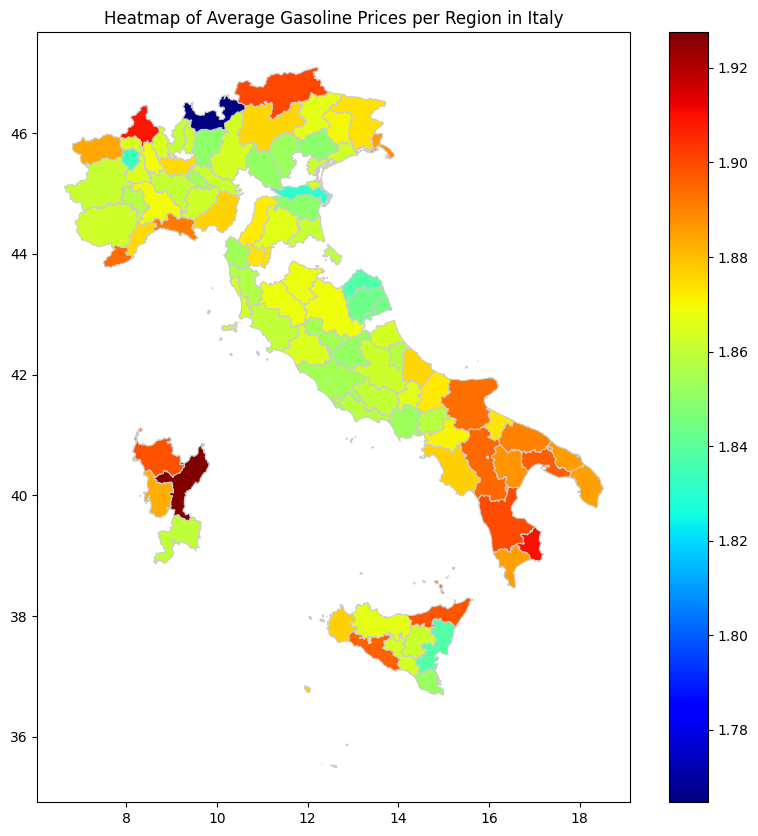

In [ ]:
region_merged['Provincia'] = region_merged['Provincia'].str.upper()
italy['NAME_2'] = italy['NAME_2'].str.upper()

# Merge the GeoDataFrame with the average price DataFrame
merged = italy.set_index('NAME_2').join(region_merged.set_index('Provincia'))

# Plot the GeoDataFrame with a color map based on the 'prezzo' column
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column='prezzo', cmap='jet', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Heatmap of Average Gasoline Prices per Region in Italy')
plt.show()